<a href="https://colab.research.google.com/github/RPFey/XJTU_NEW/blob/main/%E5%8D%A1%E5%B0%94%E6%9B%BC%E6%BB%A4%E6%B3%A2%E4%B8%8E%E7%9B%B4%E7%BA%BF%E6%8B%9F%E5%90%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 卡尔曼滤波

卡尔曼滤波用来融合不同的信息。假设你收到一串信息 eg. $\{(m_1, \sigma_1), (m_2, \sigma_2), ..., (m_n, \sigma_n)\}$。其中 $m_i$ 代表信息的估计，$\sigma_i$ 代表不确定度（方差）。可以用卡尔曼滤波方法综合利用（融合）这些信息，得到估计和不确定度。

符号规定：

1. $x_t$ 代表时刻 t 的状态变量。
2. $p_t$ 代表时刻 t 的不确定度。
3. $m_t$ 代表时刻 t 的信息。
4. $\sigma_t$ 代表时刻 t 信息的不确定度。
5. 带 hat 符号都是期望。eg. $\hat{x_t}$ 为变量 $x_t$ 的期望

假设：

**所有概率分布都是高斯分布。**

即：

$$
p(m_t | x_t) \sim N(\hat{m_t}, \sigma_t)
$$

## 单变量卡尔曼滤波

推导如下：

$$
\begin{aligned}
p(x_{t+1} | x_t, m_{t+1}) &\propto p(m_{t+1} | x_{t+1}, x_t) * p(x_{t+1} | x_{t}) \\
              &= N(\hat{m}_{t+1}, \hat{\sigma}_{t+1}) * N(\hat{x_t}, \hat{p_{t}}) \\
\end{aligned}
$$

这个分布的均值为 $\hat{x_{t+1}} = \frac{\hat{\sigma}_{t+1}^2}{\hat{p}_t^2 + \hat{\sigma}_{t+1}^2} * \hat{x}_{t} + \frac{\hat{p}_{t}^2}{\hat{p}_t^2 + \hat{\sigma}_{t+1}^2} * \hat{m}_t$，方差为 $\hat{p}_{t+1}^2 = (1 - \frac{\hat{p}_{t}^2}{\hat{p}_t^2 + \hat{\sigma}_{t+1}^2}) * \hat{p_{t}}^2$

整理后，定义卡尔曼增益 $K = \frac{\hat{p}_{t}^2}{\hat{p}_t^2 + \hat{\sigma}_{t+1}^2}$。上式可以写为：

$$
\begin{aligned}
\hat{x_{t+1}} &= (1 - K) * \hat{x}_{t} + K * \hat{m}_t \\
\hat{p}_{t+1}^2 &= (1 - K) * \hat{p_{t}}^2
\end{aligned}
$$

## 举例（PX4 高度估计）

代码段见[此处](https://github.com/PX4/PX4-ECL/blob/29243ac5cbb5d27ac71744e88afcd786df6f748d/EKF/terrain_estimator.cpp#L133)。

## 多变量卡尔曼滤波

只需要理解单变量滤波即可，多变量滤波参考公式。

完整的卡尔曼滤波为

$$
\begin{aligned}
x_k &= F_k x_{k-1} + B_k u_k + w_k\\
z_k &= H_k x_k + v_k 
\end{aligned}
$$

其中, $w_k$, $v_k$ 分别服从

$$
\begin{aligned}
w_k &\sim N(0, Q_k) \\
v_k &\sim N(0, R_k)
\end{aligned}
$$

滤波过程：运动更新

$$
\begin{aligned}
\hat{x}_k &= F_k x_{k-1} + B_k u_k\\
\hat{P}_k &= F_kP_{k-1}F_k^T +Q_k
\end{aligned}
$$

观测更新

$$
\begin{aligned}
y_k &= z_k - H_k \hat{x}_k \\
K_k &= \hat{P}_k H_k^T (H_k\hat{P}_kH_k^T + R_k)^{-1} \\
x_k &= \hat{x}_k + K_k y_k \\
P_k &= (I - K_kH_k)\hat{P}_k
\end{aligned}
$$

参考资料：

1. 《概率机器人》 (Probablistic Robots) by 塞巴斯蒂安 特龙
2. [维基百科，卡尔曼滤波](https://www.wikiwand.com/en/Kalman_filter)

In [1]:
#@markdown 导入库
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 应用：直线拟合

卡尔曼滤波可以用来拟合直线。

In [ ]:
#@markdown 二维拟合直线时，一组观测最少需要几个点
minimum_point_num = '' #@param {type:"string"}

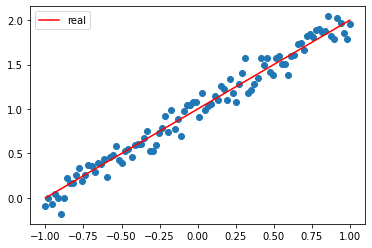

In [5]:
# 产生随机点
# 拟合直线 y = a*x + b (a = 1, b = 1)
a = 1
b = 1

N = 100 # 采样点数
x_sample = np.linspace(-1, 1, N)
y_sample = a * x_sample * a + b + np.random.normal(0, 0.1, N)

plt.figure()
plt.plot([-1, 1], [0, 2], color='r', label='real')
plt.scatter(x_sample, y_sample)
plt.legend()
plt.show()

采用最小二乘法拟合

In [13]:
X = np.stack([x_sample, np.ones((N,))], axis=0).T
Y = y_sample[:, np.newaxis]

param = np.linalg.inv(X.T @ X) @ X.T @ Y
print("parameter is: \n", param)

(100, 2)
parameter is: 
 [[1.02005858]
 [0.99799636]]


采用卡尔曼滤波拟合直线。直线的参数是 $(a, b)$。我们认为初始时，它们都是 0。协方差矩阵为 

$$
P_0 = \begin{bmatrix}
   1 & 0 \\
   0 & 1 
  \end{bmatrix}
$$

每一次的模型为

$$
\begin{bmatrix}
   y_1 \\
   y_2 
\end{bmatrix} = \begin{bmatrix}
   x_1 & 1 \\
   x_2 & 1
\end{bmatrix} * \begin{bmatrix}
  a \\
  b
\end{bmatrix} + \begin{bmatrix}
  \epsilon \\
  \epsilon
\end{bmatrix}
$$。其中 $\epsilon \sim N(0, 0.1)$。

写代码之前先思考：

每一次更新时， H是什么？R是什么？

In [23]:
param = np.array([[0.], [0.]])
var = np.array([[1., 0.], [0., 1.]])
R = np.array([[0.1, 0.], [0., 0.1]])

for i in range(N//2):
  x = np.stack([x_sample[2*i: 2*(i+1)], np.ones((2, ))], axis=0).T
  y = y_sample[2*i: 2*(i+1)][:, np.newaxis]
  K = var @ x.T @ np.linalg.inv(x @ var @ x.T + R)
  z = np.linalg.inv(x) @ y
  var = var - K @ var
  param += K @ (y - x @ param)

print("parameter is: \n", param)
print("covariance matrix is: \n", var)

parameter is: 
 [[1.07938624]
 [0.92053371]]
covariance matrix is: 
 [[-0.00989589  0.03518629]
 [ 0.02167701 -0.02961263]]


RANSAC

In [26]:
num_iteration = 1000
sample_size = 2
eps = 1e-2

best_num_inliers = -1
best_line = None

for _ in range(num_iteration):
    permuted_indices = np.random.permutation(np.arange(x_sample.shape[0]))
    sample_indices = permuted_indices[:sample_size]
    test_indices = permuted_indices[sample_size:]

    x = x_sample[sample_indices]
    y = y_sample[sample_indices]
    x = np.stack([x, np.ones((sample_size, ))], axis=0).T
    line = np.linalg.inv(x) @ y

    test_x = x_sample[test_indices]
    test_x = np.stack([test_x, np.ones((test_x.shape[0]))], axis=0).T
    test_y = y_sample[test_indices]
    error = np.abs(test_y - test_x @ line)

    num_inliers = np.sum(error < eps)
    if num_inliers > best_num_inliers:
      best_num_inliers = num_inliers
      best_line = line
    

print("the line is: ", best_line)

the line is:  [1.05763042 1.03525236]


Hough Line Transform

主要应用在图片中识别直线段。具体可以看[此处示例](https://docs.opencv.org/4.5.0/d9/db0/tutorial_hough_lines.html)